In [4]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 61.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitli

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | UnconditionalUNet | 4.0 M  | train
----------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.812    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Using device: cuda
Training a new model...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Training complete and model saved.

Running DeepCache experiments...

Running baseline (no caching)...


<ipython-input-4-75f2b7ab51f4>:367: RuntimeWarning: invalid value encountered in sqrt
  covmean = np.sqrt(real_cov @ gen_cov)


Baseline - Time: 0.14s, FID: 132.08, MSE: 0.7262
Testing DeepCache with interval=1, ratio=0.2...
Interval=1, Ratio=0.2 - Time: 0.18s (Speedup: 0.77x), FID: 123.85, MSE: 0.6911
Testing DeepCache with interval=1, ratio=0.5...
Interval=1, Ratio=0.5 - Time: 0.18s (Speedup: 0.78x), FID: 79.97, MSE: 0.7165
Testing DeepCache with interval=1, ratio=0.8...
Interval=1, Ratio=0.8 - Time: 0.18s (Speedup: 0.79x), FID: 98.73, MSE: 0.6553
Testing DeepCache with interval=1, ratio=0.9...
Interval=1, Ratio=0.9 - Time: 0.18s (Speedup: 0.78x), FID: 142.36, MSE: 0.7882
Testing DeepCache with interval=2, ratio=0.2...
Interval=2, Ratio=0.2 - Time: 0.18s (Speedup: 0.77x), FID: 84.48, MSE: 0.6683
Testing DeepCache with interval=2, ratio=0.5...
Interval=2, Ratio=0.5 - Time: 0.18s (Speedup: 0.77x), FID: 114.02, MSE: 0.7284
Testing DeepCache with interval=2, ratio=0.8...
Interval=2, Ratio=0.8 - Time: 0.18s (Speedup: 0.78x), FID: 128.67, MSE: 0.7196
Testing DeepCache with interval=2, ratio=0.9...
Interval=2, Ratio

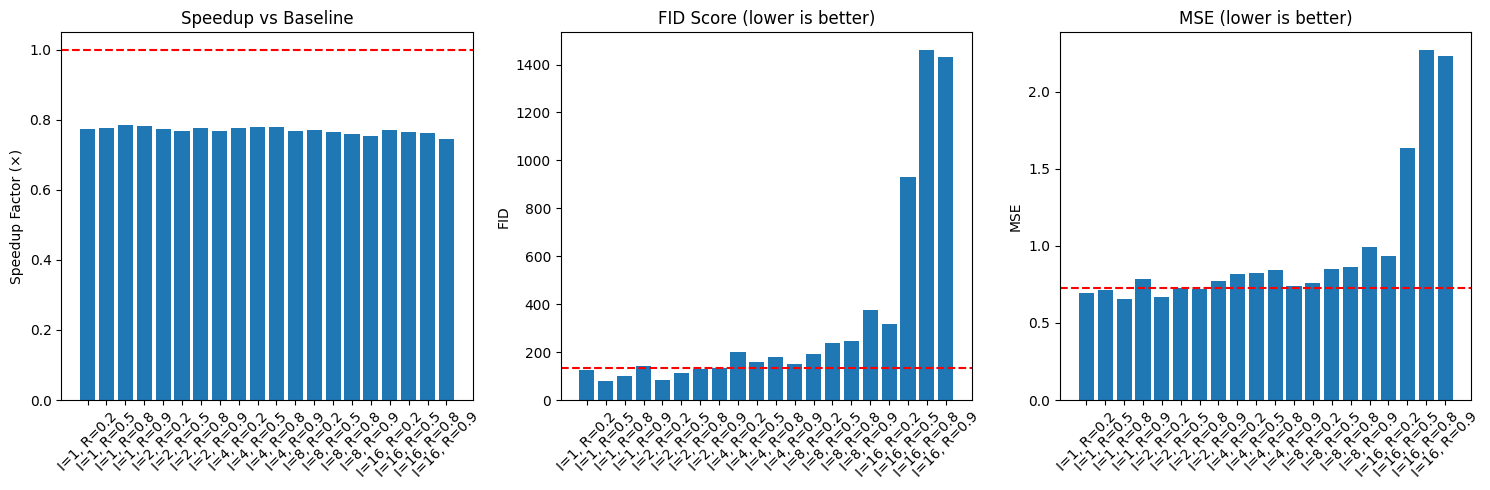

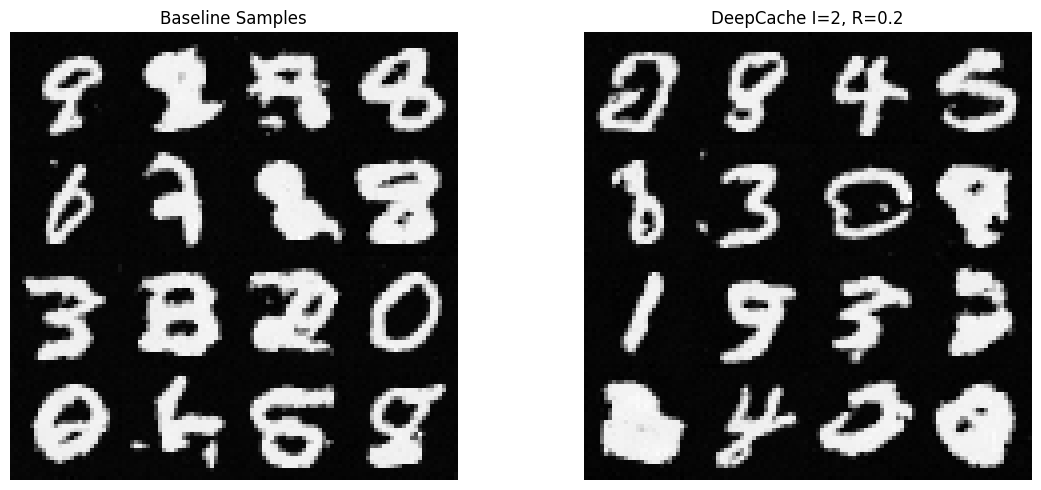

In [4]:
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from torchvision.utils import save_image

from models.DeepCache import (
    UnconditionalUNet,
    DiffusionModel,
    get_dataloader,
    run_deepcache_experiments,
    plot_metrics
)

def main():
    # Set random seed for reproducibility
    pl.seed_everything(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    unet = UnconditionalUNet(in_channels=1, base_channels=64, time_emb_dim=128).to(device)
    diffusion = DiffusionModel(unet, timesteps=1000, beta_start=1e-4, beta_end=0.02, lr=2e-4).to(device)

    print("Training the diffusion model...")
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1 if torch.cuda.is_available() else None
    )
    dataloader = get_dataloader(batch_size=128)
    trainer.fit(diffusion, dataloader)

    torch.save(diffusion.state_dict(), "diffusion_mnist.pth")
    print("Training complete and model saved.")

    # Move model to the proper device
    diffusion = diffusion.to(device)

    # Get a batch of real images for evaluation
    dataloader = get_dataloader(batch_size=64)
    real_batch, _ = next(iter(dataloader))
    real_images = real_batch[:16].to(device)  # Use 16 images for evaluation

    # Run DeepCache experiments on the diffusion model
    print("\nRunning DeepCache experiments...")
    results = run_deepcache_experiments(diffusion, real_images, num_samples=16, ddim_steps=50)

    # Analyze and visualize the experiment metrics
    best_interval, best_ratio = plot_metrics(results)

    # Generate final samples using the best DeepCache configuration
    print("\nGenerating final samples with the best DeepCache configuration...")
    final_samples, total_time, step_times = diffusion.sample_with_deepcache(
        num_samples=16,
        ddim_steps=50,
        cache_interval=best_interval,
        cache_ratio=best_ratio
    )
    save_image(final_samples, "deepcache_best_samples.png", nrow=4, normalize=True)
    print("Final samples saved to 'deepcache_best_samples.png'")

if __name__ == "__main__":
    main()
